In [ ]:
import warnings
warnings.filterwarnings("ignore")

from keras.datasets import mnist

from keras.layers import *
from keras.layers import LeakyReLU

from keras.models import Sequential , Model
from keras.optimizers import Adam
import keras
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
(X_train , _),(_,_)= mnist.load_data()

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
(X_train, _), (_, _) = mnist.load_data()
X_train = X_train / 127.5 - 1.0   # scale [0,255] → [-1,1]
X_train = np.expand_dims(X_train, axis=-1)


In [ ]:
IMG_SHAPE = (28,28,1)
NOISE_DIM = 100
BATCH_SIZE = 128
HALF_BATCH = int(BATCH_SIZE/2)
TOTAL_EPOCHS = 50
NO_OF_BATCHES = X_train.shape[0] // BATCH_SIZE


In [ ]:
def build_generator():
    model = Sequential()
    model.add(Dense(256*7*7, activation="relu", input_dim=NOISE_DIM))
    model.add(Reshape((7,7,256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=1, padding="same", activation="tanh"))
    return model


In [ ]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=IMG_SHAPE, padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


In [ ]:
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

generator = build_generator()

z = Input(shape=(NOISE_DIM,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)

combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


In [ ]:
def display_images(epoch=None, samples=25):
    noise = np.random.normal(0, 1, (samples, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # rescale from [-1,1] → [0,1]

    plt.figure(figsize=(5,5))
    for i in range(samples):
        plt.subplot(5,5,i+1)
        plt.imshow(generated_images[i].reshape(28,28), cmap='gray')
        plt.axis("off")
    if epoch:
        plt.suptitle(f"Epoch {epoch}")
    plt.show()


In [ ]:
d_losses, g_losses = [], []

for epoch in range(TOTAL_EPOCHS):
    epoch_d_loss, epoch_g_loss = 0, 0

    for step in range(NO_OF_BATCHES):
        # ---------------------
        # Train Discriminator
        # ---------------------
        idx = np.random.randint(0, X_train.shape[0], HALF_BATCH)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (HALF_BATCH, NOISE_DIM))
        fake_imgs = generator.predict(noise)

        real_y = np.ones((HALF_BATCH,1)) * 0.9   # label smoothing
        fake_y = np.zeros((HALF_BATCH,1))

        d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)

        d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        epoch_d_loss += d_loss

        # ---------------------
        # Train Generator
        # ---------------------
        noise = np.random.normal(0,1,(BATCH_SIZE, NOISE_DIM))
        y = np.ones((BATCH_SIZE,1))

        g_loss = combined.train_on_batch(noise, y)
        epoch_g_loss += g_loss

    d_losses.append(epoch_d_loss / NO_OF_BATCHES)
    g_losses.append(epoch_g_loss / NO_OF_BATCHES)

    print(f"Epoch {epoch+1}/{TOTAL_EPOCHS} | D Loss: {d_losses[-1]:.4f} | G Loss: {g_losses[-1]:.4f}")

    if (epoch+1) % 10 == 0:
        display_images(epoch+1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step


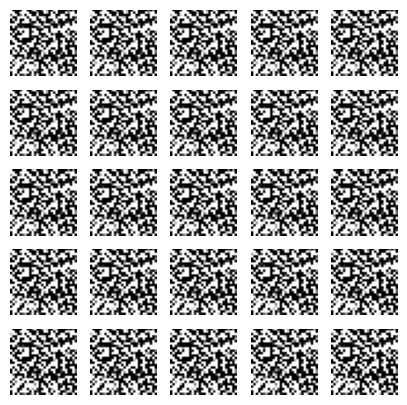

In [ ]:
display_images()
